In [4]:
%load_ext autoreload
%autoreload 2

In [35]:
import cdsapi
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from models import CNN1D, FFN
from data_utils import FloodDataset
import umap
import iisignature

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# This notebook

In this notebook we explore the [river discharge and related historical data from the European Flood Awareness System](https://ewds.climate.copernicus.eu/datasets/efas-historical?tab=download). We are interested in modelling the river flow using discharge in the last 6 hours `dis06` to predict high future discharge. For each grid point, we compute a threshold of the 95th percentile which is used to generate a binary label indicating high discharge, which may be indiciative of higher flood risk. The experiments can be modified with different observation and window predictions, currently given a `72` hour prediction window we predict whether high discharge will occur in the next `6` hours. We note that this is a contrived example intended for this simple demo. 

We then compute path signature representations of the sequences, which are lower dimensional fixed length vector representations of temporal data. These are used to train the same models for comparison. 

For the raw data we train a `1DCNN` and a `feedforward` neural net. And for the path signatures vectors it is not appropraite to train a convolutional network so we train just the `feedforward` net.

# Load data

## try using API (**currently not working**)

In [6]:
"""
TODO: 400 error on this API request, structure is missing from docs:
https://ewds.climate.copernicus.eu/datasets/efas-historical?tab=download

And example query returns the same error:
https://ewds.climate.copernicus.eu/how-to-api
"""
c = cdsapi.Client()

c.retrieve(
    "efas-historical",
    {
        "system_version": "version_5_0",
        "variable": "river_discharge_in_the_last_6_hours",
        "hyear": "2020",
        "month": ["01", "02", "03"],
        "day": ["01", "02", "03"],
        "time": ["00:00", "06:00", "12:00", "18:00"],
        "area": [52, 5, 48, 10],  # N, W, S, E (central europe box)
        "format": "zip",
    },
    "efas_demo.zip"
)


2025-08-26 09:41:26,398 INFO [2024-09-26T00:00:00] Watch our [Forum]( https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-26 09:41:26,572 INFO [2024-02-01T00:00:00] Please note that accessing this dataset via CDS for time-critical operation is not advised or supported
2025-08-26 09:41:26,575 INFO [2024-02-01T00:00:00] Please note that we suggest checking the list of known issues on the EFAS wiki
[here](https://confluence.ecmwf.int/display/CEMS/EFAS+-+Known+Issues)
before downloading the dataset.
2025-08-26 09:41:26,577 INFO Request ID is 7a6a8055-0d18-48dd-91a6-09f010b1ccc0
2025-08-26 09:41:26,653 INFO status has been updated to accepted
2025-08-26 09:41:35,085 INFO status has been updated to running
2025-08-26 09:41:40,227 INFO status has been updated to failed


HTTPError: 400 Client Error: Bad Request for url: https://ewds.climate.copernicus.eu/api/retrieve/v1/jobs/7a6a8055-0d18-48dd-91a6-09f010b1ccc0/results
The job has failed
The job failed with: MultiAdaptorNoDataError

## load manually downloaded data

In [7]:
try:
    dset = xr.open_dataset("./data/historical_discharge.grib", engine="cfgrib")
    print(dset)
except Exception as e:
    print(f"dataset failed to load: {e}")

<xarray.Dataset> Size: 36MB
Dimensions:     (time: 124, latitude: 240, longitude: 300)
Coordinates:
  * time        (time) datetime64[ns] 992B 2020-01-01 ... 2020-01-31T18:00:00
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 2kB 51.99 51.98 51.96 ... 48.04 48.02 48.01
  * longitude   (longitude) float64 2kB 5.008 5.025 5.042 ... 9.958 9.975 9.992
    valid_time  (time) datetime64[ns] 992B ...
Data variables:
    dis06       (time, latitude, longitude) float32 36MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-08-26T09:41 GRIB to CDM+CF via cfgrib-0.9.1...


/home/fergus/miniconda3/envs/fathom-env/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [8]:
print(dset.variables)

Frozen({'time': <xarray.IndexVariable 'time' (time: 124)> Size: 992B
array(['2020-01-01T00:00:00.000000000', '2020-01-01T06:00:00.000000000',
       '2020-01-01T12:00:00.000000000', '2020-01-01T18:00:00.000000000',
       '2020-01-02T00:00:00.000000000', '2020-01-02T06:00:00.000000000',
       '2020-01-02T12:00:00.000000000', '2020-01-02T18:00:00.000000000',
       '2020-01-03T00:00:00.000000000', '2020-01-03T06:00:00.000000000',
       '2020-01-03T12:00:00.000000000', '2020-01-03T18:00:00.000000000',
       '2020-01-04T00:00:00.000000000', '2020-01-04T06:00:00.000000000',
       '2020-01-04T12:00:00.000000000', '2020-01-04T18:00:00.000000000',
       '2020-01-05T00:00:00.000000000', '2020-01-05T06:00:00.000000000',
       '2020-01-05T12:00:00.000000000', '2020-01-05T18:00:00.000000000',
       '2020-01-06T00:00:00.000000000', '2020-01-06T06:00:00.000000000',
       '2020-01-06T12:00:00.000000000', '2020-01-06T18:00:00.000000000',
       '2020-01-07T00:00:00.000000000', '2020-01-07T06:

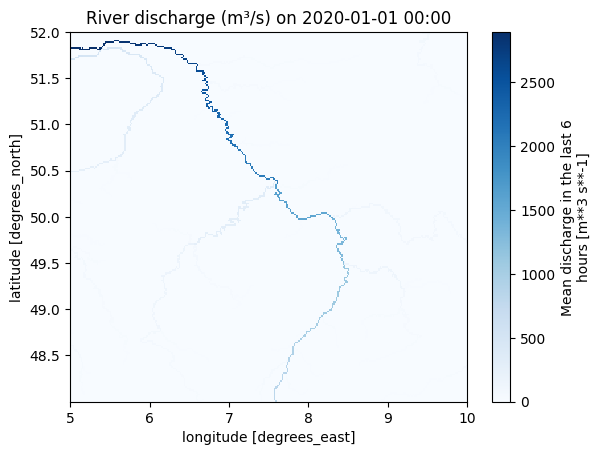

In [10]:
# visualise whole dataset discharge at a single time
dset['dis06'].isel(time=0).plot(cmap='Blues')
plt.title("River discharge (m³/s) on 2020-01-01 00:00")
plt.show()

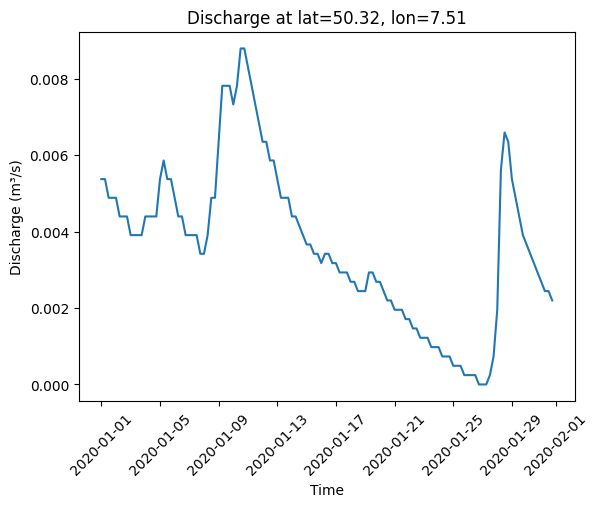

In [11]:
# visualise temporal dischage of single lat/long
lat_idx = 100
lon_idx = 150
dis = dset['dis06']
time_index = dis['time']

plt.plot(time_index, dis[:, lat_idx, lon_idx])
plt.xlabel("Time")
plt.ylabel("Discharge (m³/s)")
plt.title(f"Discharge at lat={dis.latitude[lat_idx].values:.2f}, lon={dis.longitude[lon_idx].values:.2f}")
plt.xticks(rotation=45)
plt.show()


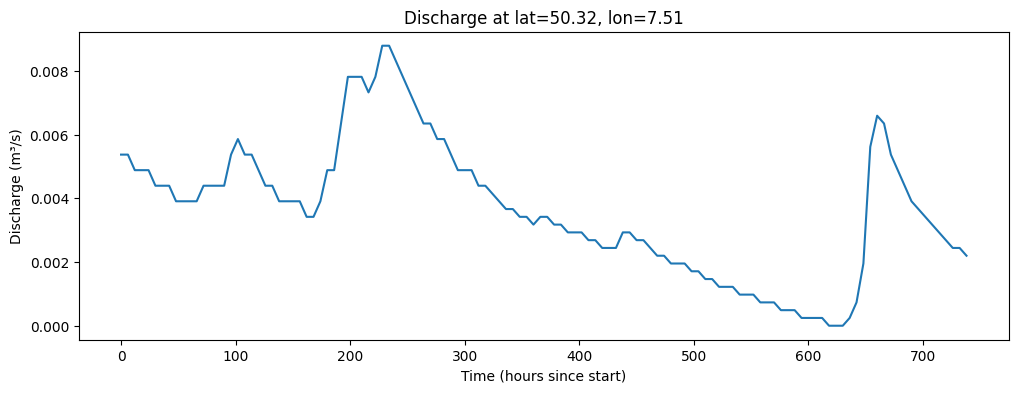

In [12]:
lat_idx = 100
lon_idx = 150

# select the time series
ts = dis.isel(latitude=lat_idx, longitude=lon_idx).values  # shape: (time,)

# numeric time axis (hours since start)
time_numeric = np.arange(len(ts)) * 6  # dataset is 6-hourly, multiply index by 6 for hours

plt.figure(figsize=(12, 4))
plt.plot(time_numeric, ts)
plt.xlabel("Time (hours since start)")
plt.ylabel("Discharge (m³/s)")
plt.title(f"Discharge at lat={dis.latitude[lat_idx].values:.2f}, lon={dis.longitude[lon_idx].values:.2f}")
plt.show()


# simple binary prediction task
**Objective**:

Predict whether river discharge at a given location and time exceeds a flood threshold. This will be framed as a binary classification problem.

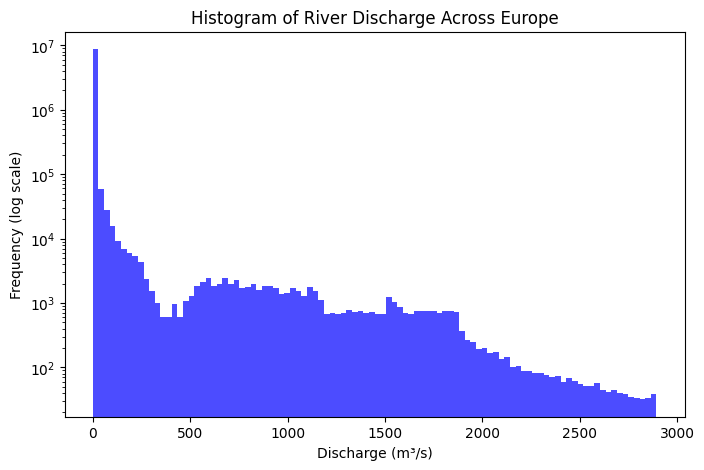

Number of filtered grid points: 756 / 72000


In [13]:
THRESHOLD_FOR_SELECTION = 500 # m^3/s
dis = dset['dis06']

# discharge data: shape (time, lat, lon)
dis_values = dis.values

# 95th percentile per grid point
flood_thresholds = np.percentile(dis_values, 95, axis=0)

all_flows = dis.values.flatten()
plt.figure(figsize=(8,5))
plt.hist(all_flows, bins=100, color='blue', alpha=0.7)
plt.yscale('log')  # log scale helps see heavy tails
plt.xlabel("Discharge (m³/s)")
plt.ylabel("Frequency (log scale)")
plt.title("Histogram of River Discharge Across Europe")
plt.show()

# flatten spatial dimensions for selection
flood_thresholds_flat = flood_thresholds.flatten()
filter_mask = flood_thresholds_flat > THRESHOLD_FOR_SELECTION
n_points = np.sum(filter_mask)
print(f"Number of filtered grid points: {n_points} / {flood_thresholds_flat.size}")

# apply mask to the discharge values
dis_values_flat = dis_values.reshape(dis_values.shape[0], -1)  # shape: (time, n_lat*n_lon)
dis_values_filtered = dis_values_flat[:, filter_mask]          # shape: (time, n_points)
flood_thresholds_filtered = flood_thresholds_flat[filter_mask]


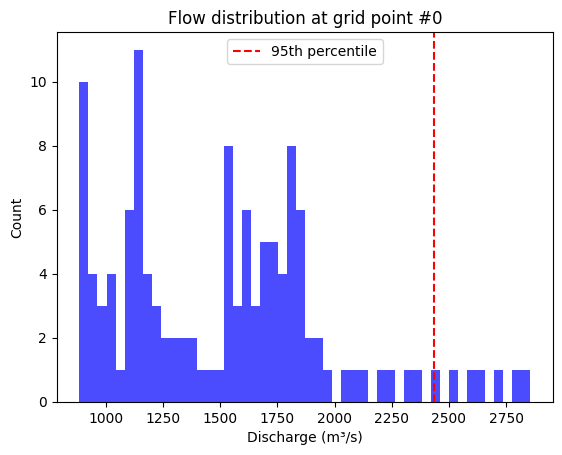

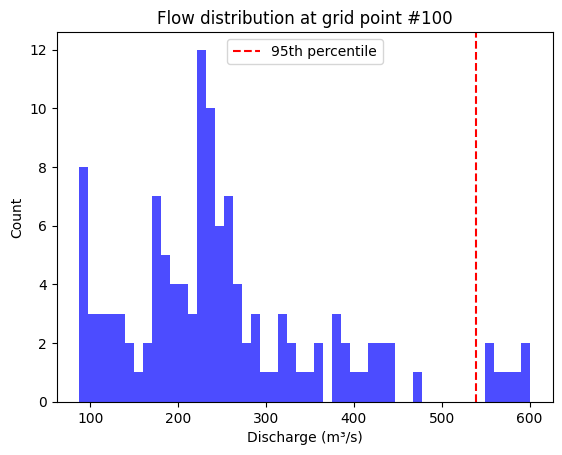

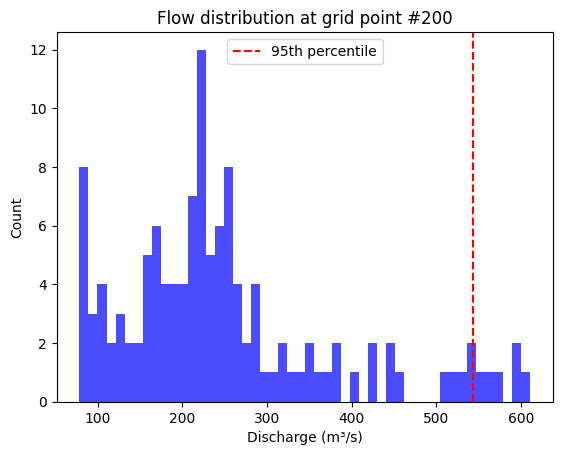

In [14]:
# visualise some representative active points
# pick first 3 active points as examples
sample_points = [0, 100, 200]  # indices into dis_values_active

for idx in sample_points:
    plt.hist(dis_values_filtered[:, idx], bins=50, alpha=0.7, color='blue')
    plt.axvline(flood_thresholds_filtered[idx], color='red', linestyle='--', label='95th percentile')
    plt.title(f"Flow distribution at grid point #{idx}")
    plt.xlabel("Discharge (m³/s)")
    plt.ylabel("Count")
    plt.legend()
    plt.show()


In [ ]:
T_obs = 12   # observation window (timesteps)
T_pred = 1   # prediction horizon (timesteps)

# build dataset for filtered grid points
n_time, n_filtered = dis_values_filtered.shape
X = []
y = []

for t in range(n_time - T_obs - T_pred + 1):
    # input sequence for all filtered points
    X.append(dis_values_filtered[t:t+T_obs, :])  # (T_obs, n_filtered)

    # label: flood if any timestep in prediction window exceeds threshold
    # future_window = dis_values_filtered[t+T_obs:t+T_obs+T_pred, :]
    # TODO: currently experimenting with a 1 timestep gap between obs window and label window, to avoid "leakage"
    future_window = dis_values_filtered[t+T_obs+1 : t+T_obs+1+T_pred, :] 
    future_label = (future_window >= flood_thresholds_filtered[None, :]).any(axis=0)
    y.append(future_label)

X = np.array(X)  # (n_samples, T_obs, n_filtered)
y = np.array(y)  # (n_samples, n_filtered)

print("X shape:", X.shape)
print("y shape:", y.shape)

# flatten for training
n_samples, T_obs, n_filtered = X.shape
X_flat = X.transpose(0, 2, 1).reshape(-1, T_obs)  # (n_samples*n_filtered, T_obs)
y_flat = y.reshape(-1)                            # (n_samples*n_filtered,)

# normalise (z-score) across the dataset
mean = X_flat.mean(axis=0, keepdims=True)
std = X_flat.std(axis=0, keepdims=True) + 1e-6
X_flat = (X_flat - mean) / std

X shape: (112, 12, 756)
y shape: (112, 756)


In [71]:
def create_datasets(X, y):
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y,
        test_size=0.3,   # 30% held out for val+test
        stratify=y,
        random_state=42
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,   # split 50/50 → 15% val, 15% test
        stratify=y_temp,
        random_state=42
    )

    train_ds = FloodDataset(X_train, y_train)
    val_ds   = FloodDataset(X_val, y_val)
    test_ds  = FloodDataset(X_test, y_test)

    print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
    print("Labels train:", np.unique(y_train, return_counts=True))
    print("Labels val:  ", np.unique(y_val, return_counts=True))
    print("Labels test: ", np.unique(y_test, return_counts=True))

    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False)

    print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")
    
    return train_loader, val_loader, test_loader

def train_model(train_dict, train_loader, val_loader):
    train_losses = []
    val_losses = []

    model = train_dict['model']
    model_name = train_dict['model_name']
    device = train_dict['device']
    optimizer = train_dict['optimizer']
    criterion = train_dict['criterion']
    n_epochs = train_dict['n_epochs']
    verbose = train_dict['verbose']

    for epoch in (pbar := tqdm(range(n_epochs))):
        if len(train_losses) > 0:
            pbar.set_description(f"train loss: {train_losses[-1]:.2f}")
        else:
            pbar.set_description(f"train loss: N/A")
        
        # train
        model.train()
        running_train_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device).float()
            optimizer.zero_grad()
            out = model(x_batch).squeeze()
            loss = criterion(out, y_batch)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * x_batch.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device).float()
                out = model(x_batch).squeeze()
                loss = criterion(out, y_batch)
                running_val_loss += loss.item() * x_batch.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        if verbose: print(f"Epoch {epoch+1:03d} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

    # plot losses
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss for {model_name}")
    plt.legend()
    plt.show()

def test_model(test_dict, test_loader):
    model = test_dict['model']
    model_name = test_dict['model_name']
    device = test_dict['device']
    criterion = test_dict['criterion']
    
    # evaluate on test set and collect everything for metrics + UMAP
    model.eval()
    all_preds = []
    all_targets = []
    all_embeddings = []
    all_probs = []

    test_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device).float()

            # forward pass
            logits = model(x_batch)
            out = logits.squeeze()

            # loss
            loss = criterion(out, y_batch)
            test_loss += loss.item() * x_batch.size(0)

            # store preds + targets
            all_preds.append(out.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

            # store embeddings
            emb = model.embed(x_batch)   # (batch, 32)
            all_embeddings.append(emb.cpu().numpy())

            # store probabilities
            if logits.shape[1] == 1:  # binary, single logit
                probs = logits.squeeze()
            all_probs.append(probs.cpu().numpy())

    # combine everything
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    all_embeddings = np.concatenate(all_embeddings)
    all_probs = np.concatenate(all_probs)

    # find optimal threshold based on F1
    thresholds = np.linspace(0, 1, 101)
    f1_scores = []

    for t in thresholds:
        preds_t = (all_preds >= t).astype(int)
        f1_scores.append(f1_score(all_targets, preds_t))

    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    print(f"Optimal threshold (max F1): {best_threshold:.2f}, F1: {best_f1:.4f}")

    # use optimal threshold for binary predictions
    binary_preds = (all_preds >= best_threshold).astype(int)

    # metrics
    test_loss /= len(test_loader.dataset)
    acc   = accuracy_score(all_targets, binary_preds)
    auroc = roc_auc_score(all_targets, all_preds)
    auprc = average_precision_score(all_targets, all_preds)
    f1    = f1_score(all_targets, binary_preds)

    print("\n--- Test Set Performance ---")
    print(f"Loss: {test_loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"AUROC: {auroc:.4f}")
    print(f"AUPRC: {auprc:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # confusion matrix with optimized threshold
    cm = confusion_matrix(all_targets, binary_preds)
    plt.figure(figsize=(5,5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Lower Flow", "Higher Flow"])
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title(f"{model_name} Confusion Matrix (Threshold={best_threshold:.2f})")
    plt.show()

    # UMAP
    reducer = umap.UMAP(n_components=2, random_state=42)
    embedding_2d = reducer.fit_transform(all_embeddings)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # left: probabilities
    sc1 = axes[0].scatter(
        embedding_2d[:,0], embedding_2d[:,1],
        c=all_probs, cmap="coolwarm", s=10, alpha=0.7
    )
    cbar1 = fig.colorbar(sc1, ax=axes[0])
    cbar1.set_label("Model probability of positive class")
    axes[0].set_title(f"{model_name} UMAP (colored by probability)")
    axes[0].set_xlabel("UMAP1")
    axes[0].set_ylabel("UMAP2")

    # right: ground truth
    sc2 = axes[1].scatter(
        embedding_2d[:,0], embedding_2d[:,1],
        c=all_targets, cmap="coolwarm", s=10, alpha=0.7
    )
    cbar2 = fig.colorbar(sc2, ax=axes[1])
    cbar2.set_label("True label")
    axes[1].set_title(f"{model_name} (colored by ground truth)")
    axes[1].set_xlabel("UMAP1")
    axes[1].set_ylabel("UMAP2")

    plt.tight_layout()
    plt.show()


Train: (59270, 12) Val: (12701, 12) Test: (12701, 12)
Labels train: (array([False,  True]), array([57783,  1487]))
Labels val:   (array([False,  True]), array([12382,   319]))
Labels test:  (array([False,  True]), array([12382,   319]))
Train: 59270, Val: 12701, Test: 12701


train loss: N/A:   0%|          | 0/20 [00:00<?, ?it/s]

train loss: 0.01: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


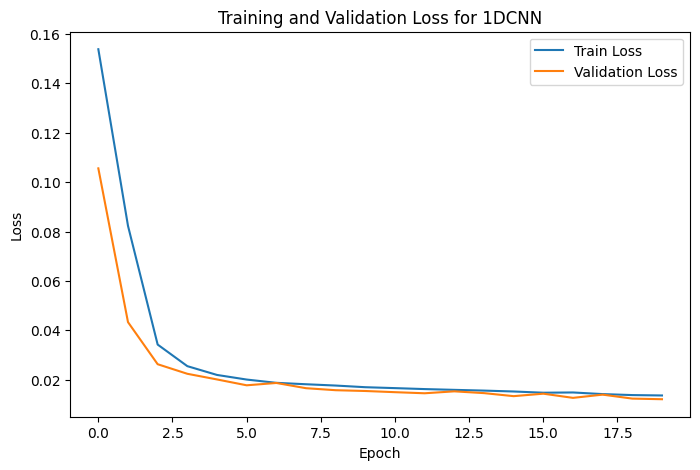

In [72]:
train_loader, val_loader, test_loader = create_datasets(X_flat, y_flat)

train_dict = {}
train_dict['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dict['model'] = CNN1D(T_obs=X.shape[1]).to(train_dict['device'])
train_dict['model_name'] = "1DCNN"
train_dict['criterion'] = nn.BCELoss()
train_dict['optimizer'] = torch.optim.Adam(train_dict['model'].parameters(), lr=1e-3)
train_dict['verbose'] = False
train_dict['n_epochs'] = 20 

train_model(
    train_dict,
    train_loader,
    val_loader
)

Optimal threshold (max F1): 0.55, F1: 0.8861

--- Test Set Performance ---
Loss: 0.0138
Accuracy: 0.9943
AUROC: 0.9989
AUPRC: 0.9634
F1-Score: 0.8861


<Figure size 500x500 with 0 Axes>

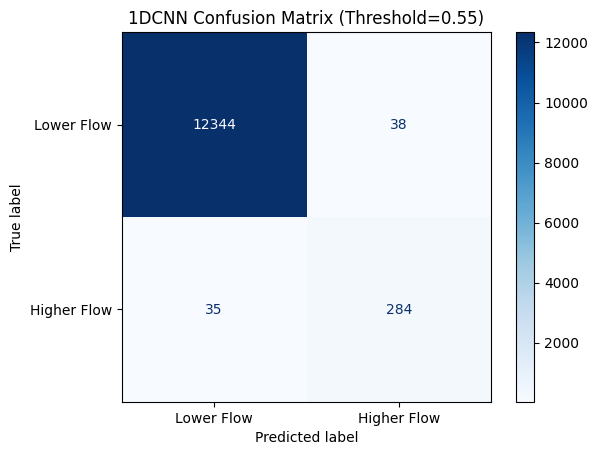

/home/fergus/miniconda3/envs/fathom-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


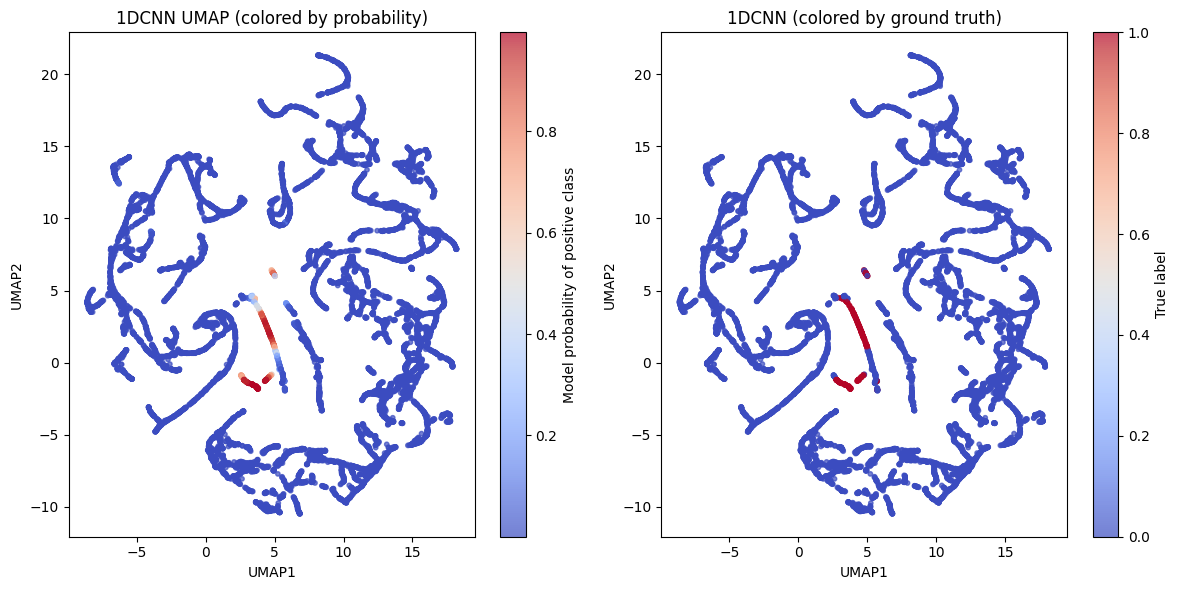

In [73]:
test_dict = {}
test_dict['model'] = train_dict['model']
test_dict['model_name'] = "1DCNN"
test_dict['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
test_dict['criterion'] = nn.BCELoss()

test_model(
    test_dict,
    test_loader
)

Train: (59270, 12) Val: (12701, 12) Test: (12701, 12)
Labels train: (array([False,  True]), array([57783,  1487]))
Labels val:   (array([False,  True]), array([12382,   319]))
Labels test:  (array([False,  True]), array([12382,   319]))
Train: 59270, Val: 12701, Test: 12701


train loss: N/A:   0%|          | 0/50 [00:00<?, ?it/s]

train loss: 0.01: 100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


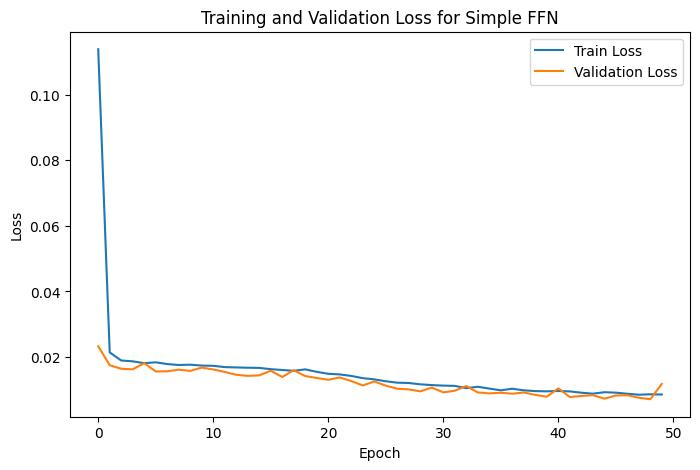

In [74]:
train_loader, val_loader, test_loader = create_datasets(X_flat, y_flat)

train_dict = {}
train_dict['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dict['model'] = FFN(T_obs=X.shape[1]).to(train_dict['device'])
train_dict['model_name'] = "Simple FFN"
train_dict['criterion'] = nn.BCELoss()
train_dict['optimizer'] = torch.optim.Adam(train_dict['model'].parameters(), lr=1e-3)
train_dict['verbose'] = False
train_dict['n_epochs'] = 50

train_model(
    train_dict,
    train_loader,
    val_loader
)

Optimal threshold (max F1): 0.74, F1: 0.9403

--- Test Set Performance ---
Loss: 0.0129
Accuracy: 0.9969
AUROC: 0.9996
AUPRC: 0.9838
F1-Score: 0.9403


<Figure size 500x500 with 0 Axes>

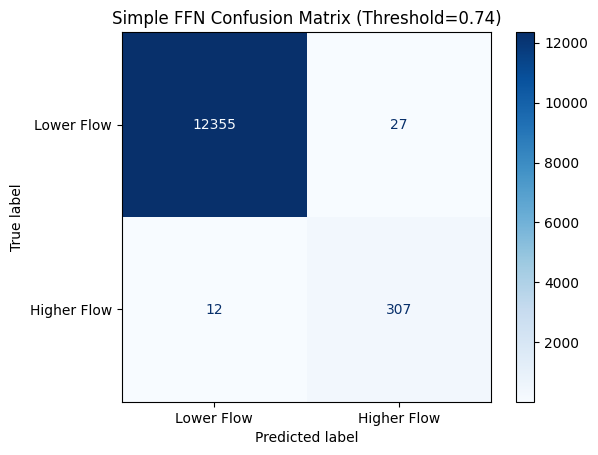

/home/fergus/miniconda3/envs/fathom-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


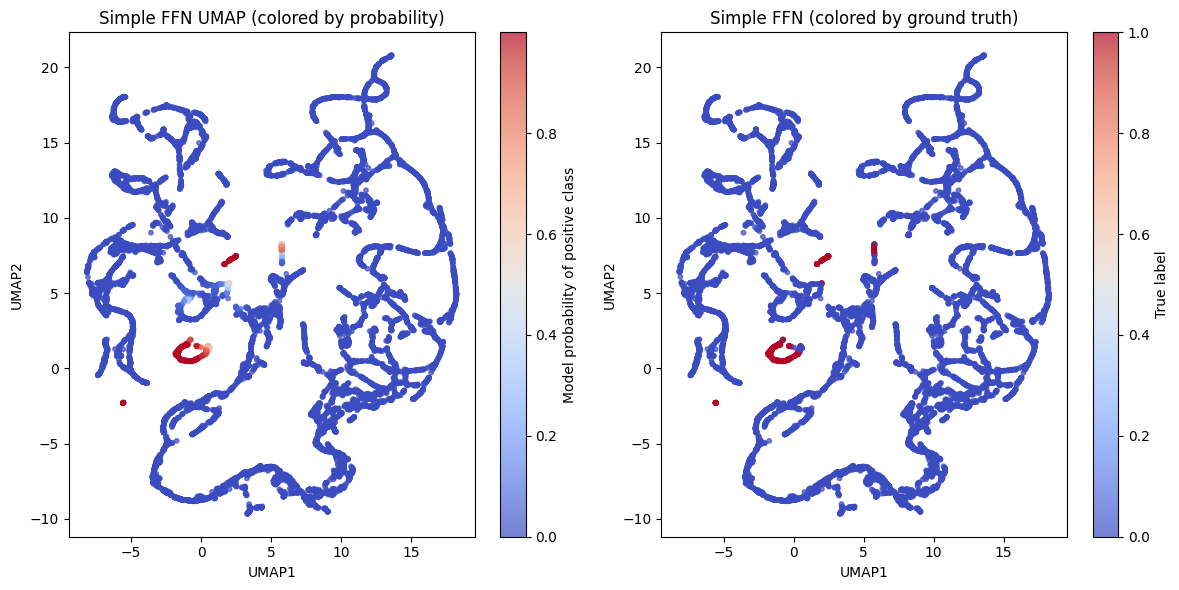

In [75]:
test_dict = {}
test_dict['model'] = train_dict['model']
test_dict['model_name'] = "Simple FFN"
test_dict['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
test_dict['criterion'] = nn.BCELoss()

test_model(
    test_dict,
    test_loader
)

# Path signatures
The output of the path is a fixed length vector representation the size of the `level` of the path.

In [64]:
def get_signature(data_list, level) -> np.ndarray:
    sig_list = []
    for path in data_list:
        # feature dimension is required, (T_obs,) -> (T_obs, 1)
        path = path.reshape(-1, 1)
        sig_list.append(iisignature.sig(path, level))

    return np.asarray(sig_list)

level_1_paths = get_signature(data_list=X_flat, level=1)
level_2_paths = get_signature(data_list=X_flat, level=2)
level_3_paths = get_signature(data_list=X_flat, level=3)
level_4_paths = get_signature(data_list=X_flat, level=4)

Processing path level: 1
Train: (59270, 1) Val: (12701, 1) Test: (12701, 1)
Labels train: (array([False,  True]), array([57783,  1487]))
Labels val:   (array([False,  True]), array([12382,   319]))
Labels test:  (array([False,  True]), array([12382,   319]))
Train: 59270, Val: 12701, Test: 12701


train loss: N/A:   0%|          | 0/20 [00:00<?, ?it/s]

train loss: 0.05: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


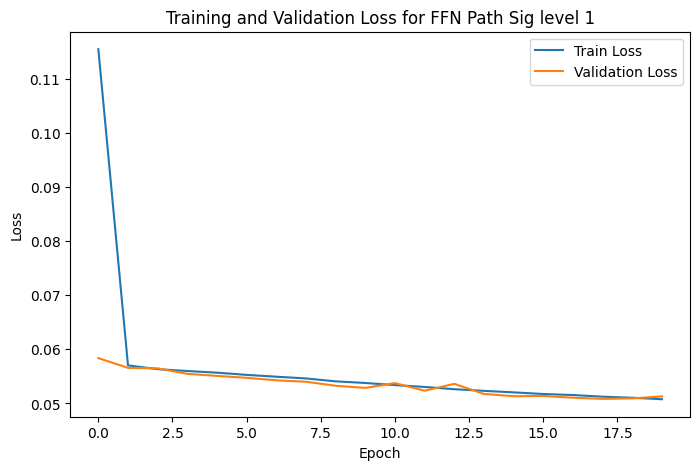

Optimal threshold (max F1): 0.27, F1: 0.5560

--- Test Set Performance ---
Loss: 0.0522
Accuracy: 0.9716
AUROC: 0.9773
AUPRC: 0.4431
F1-Score: 0.5560


<Figure size 500x500 with 0 Axes>

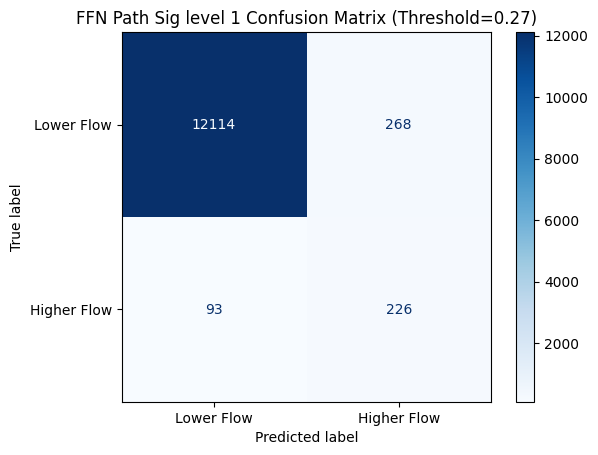

/home/fergus/miniconda3/envs/fathom-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


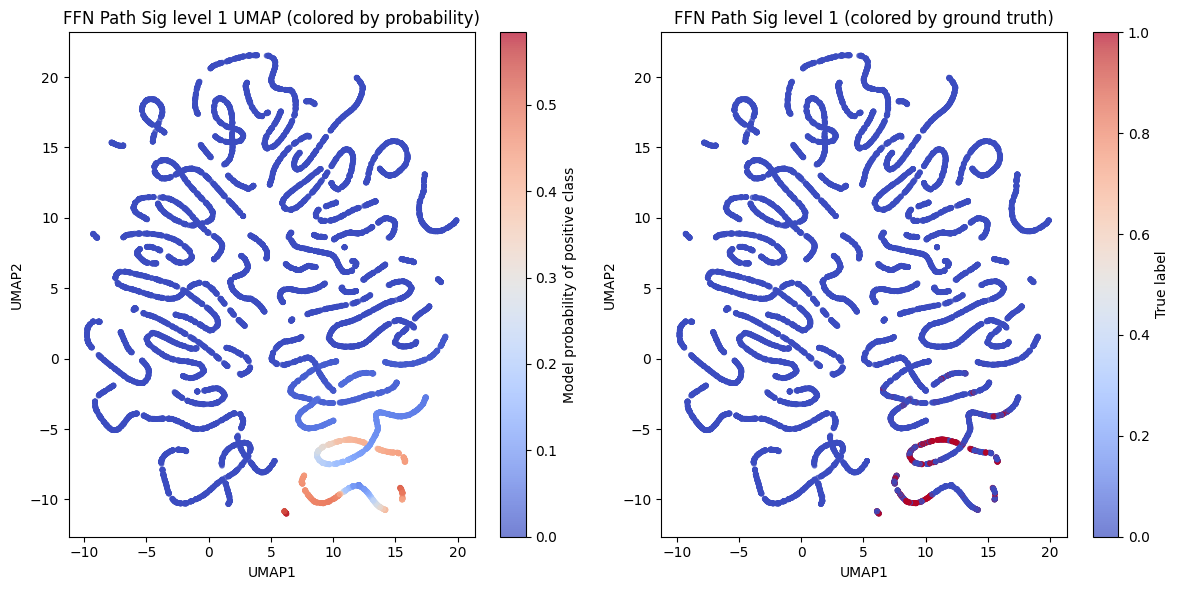

Processing path level: 2
Train: (59270, 2) Val: (12701, 2) Test: (12701, 2)
Labels train: (array([False,  True]), array([57783,  1487]))
Labels val:   (array([False,  True]), array([12382,   319]))
Labels test:  (array([False,  True]), array([12382,   319]))
Train: 59270, Val: 12701, Test: 12701


train loss: 0.05: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


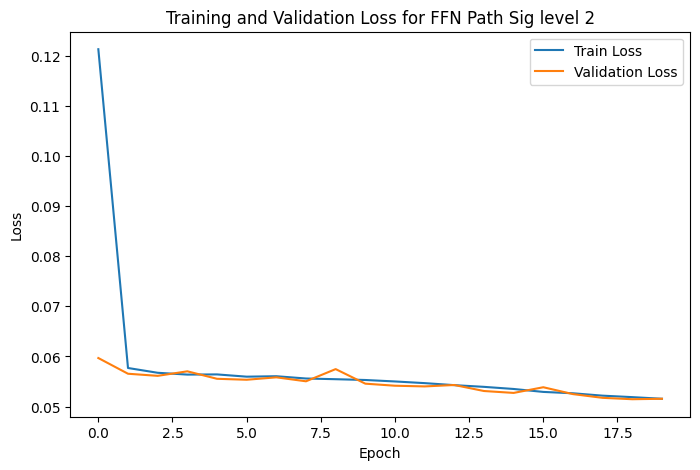

Optimal threshold (max F1): 0.20, F1: 0.5788

--- Test Set Performance ---
Loss: 0.0527
Accuracy: 0.9718
AUROC: 0.9782
AUPRC: 0.4919
F1-Score: 0.5788


<Figure size 500x500 with 0 Axes>

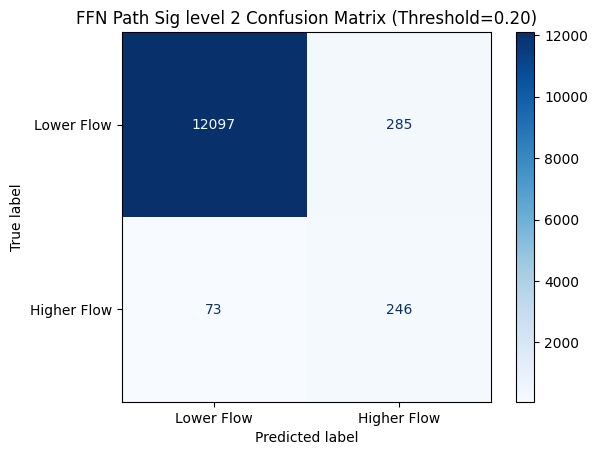

/home/fergus/miniconda3/envs/fathom-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


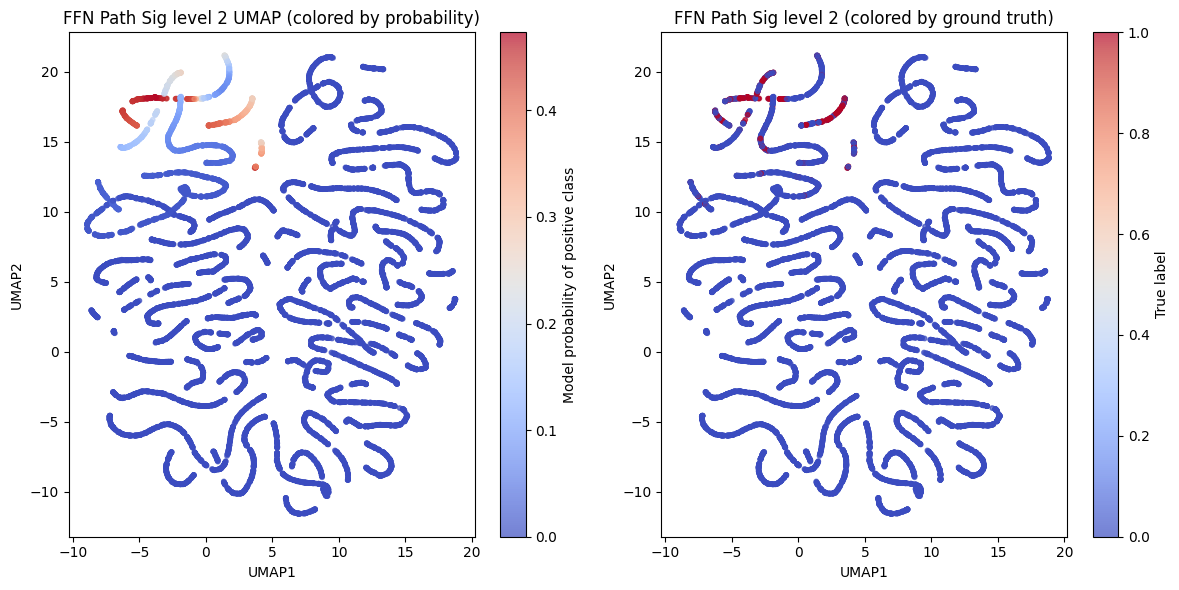

Processing path level: 3
Train: (59270, 3) Val: (12701, 3) Test: (12701, 3)
Labels train: (array([False,  True]), array([57783,  1487]))
Labels val:   (array([False,  True]), array([12382,   319]))
Labels test:  (array([False,  True]), array([12382,   319]))
Train: 59270, Val: 12701, Test: 12701


train loss: 0.05: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


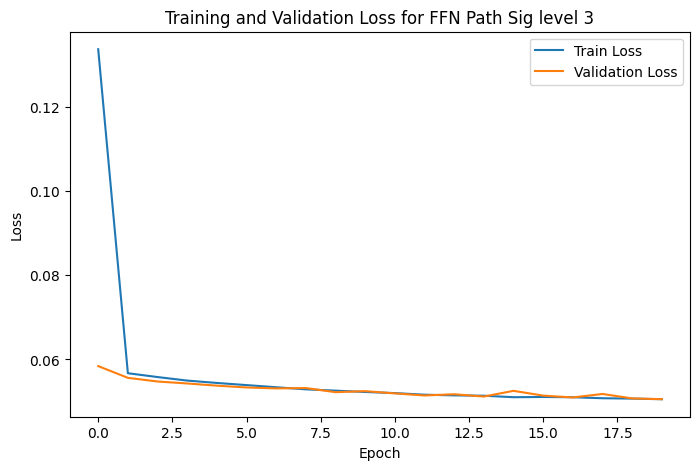

Optimal threshold (max F1): 0.27, F1: 0.5949

--- Test Set Performance ---
Loss: 0.0509
Accuracy: 0.9739
AUROC: 0.9792
AUPRC: 0.4976
F1-Score: 0.5949


<Figure size 500x500 with 0 Axes>

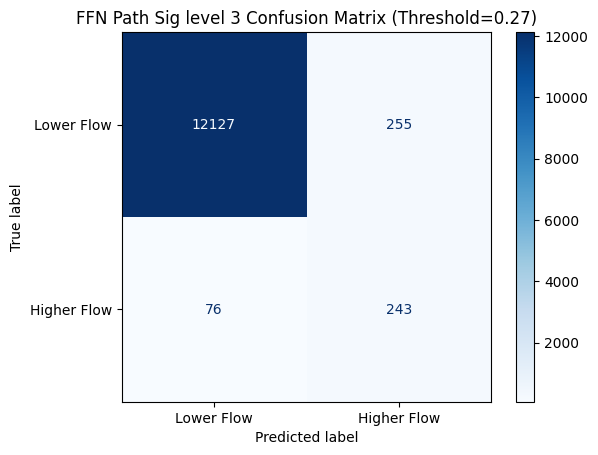

/home/fergus/miniconda3/envs/fathom-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


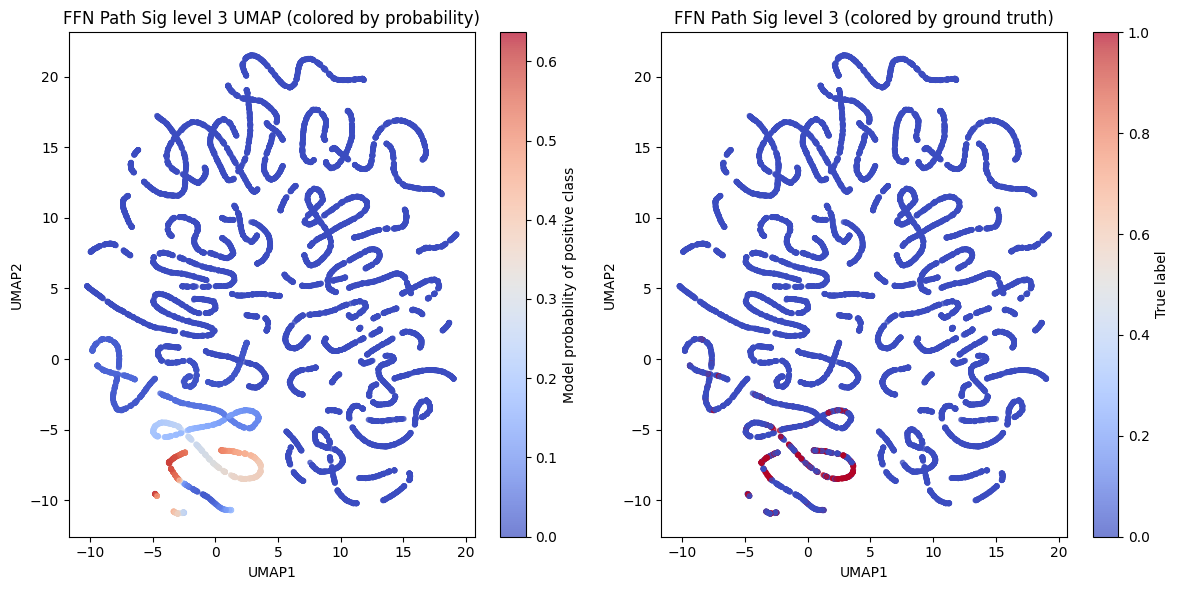

Processing path level: 4
Train: (59270, 4) Val: (12701, 4) Test: (12701, 4)
Labels train: (array([False,  True]), array([57783,  1487]))
Labels val:   (array([False,  True]), array([12382,   319]))
Labels test:  (array([False,  True]), array([12382,   319]))
Train: 59270, Val: 12701, Test: 12701


train loss: 0.05: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


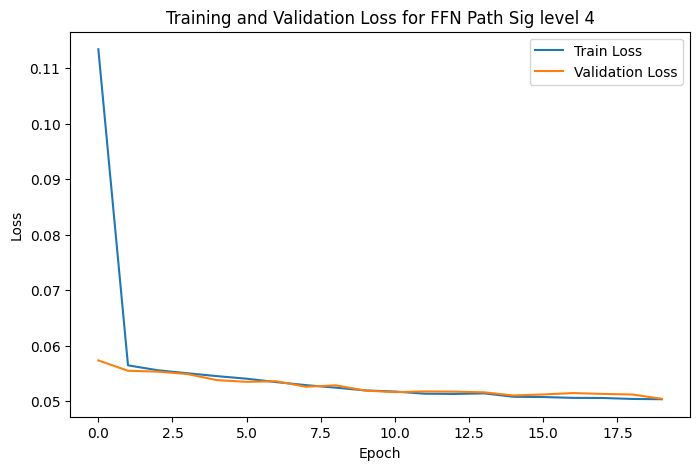

Optimal threshold (max F1): 0.26, F1: 0.5945

--- Test Set Performance ---
Loss: 0.0506
Accuracy: 0.9735
AUROC: 0.9794
AUPRC: 0.4909
F1-Score: 0.5945


<Figure size 500x500 with 0 Axes>

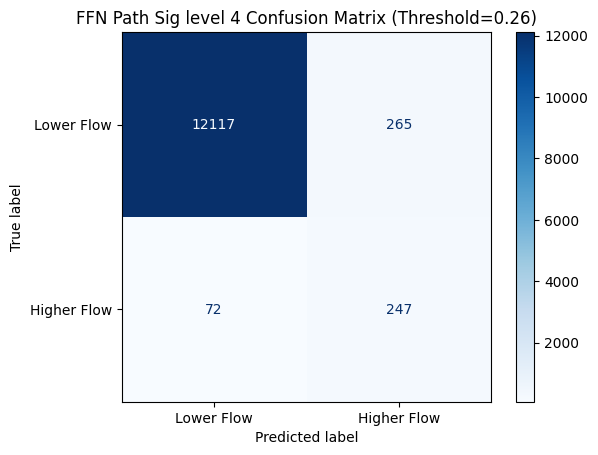

/home/fergus/miniconda3/envs/fathom-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


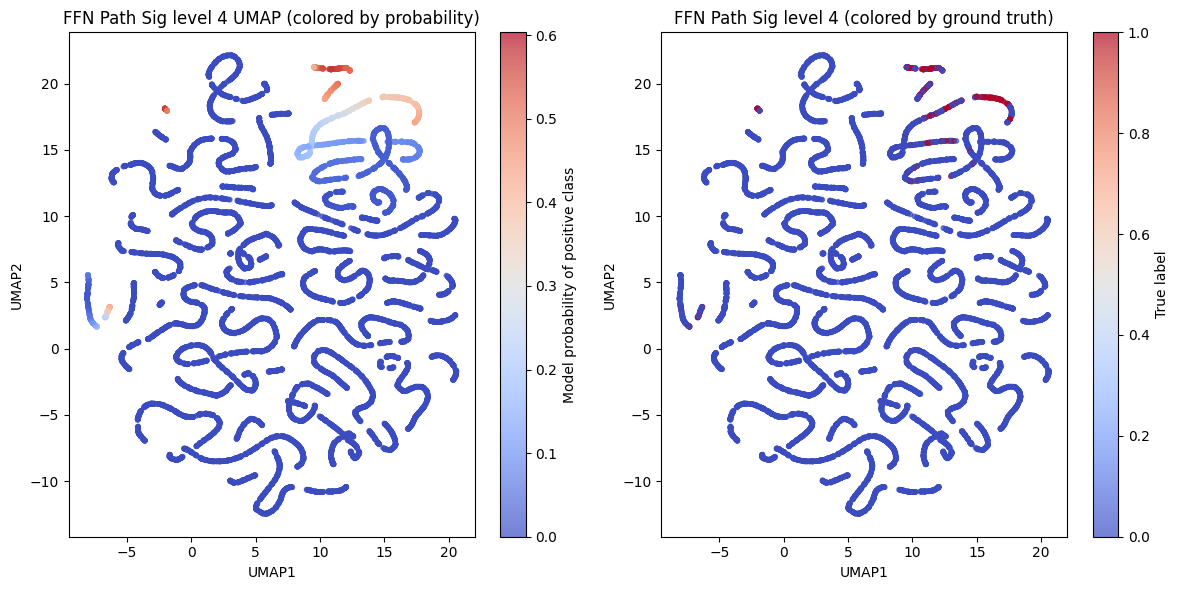

In [76]:
for level, path_level_data in enumerate([level_1_paths, level_2_paths, level_3_paths, level_4_paths]):
    print(f"Processing path level: {level+1}")
    X_paths = path_level_data
    train_loader, val_loader, test_loader = create_datasets(X_paths, y_flat)

    train_dict['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_dict['model'] = FFN(T_obs=X_paths.shape[1]).to(train_dict['device'])
    train_dict['model_name'] = f"FFN Path Sig level {level+1}"
    train_dict['criterion'] = nn.BCELoss()
    train_dict['optimizer'] = torch.optim.Adam(train_dict['model'].parameters(), lr=1e-3)
    train_dict['verbose'] = False
    train_dict['n_epochs'] = 20 

    train_model(
        train_dict,
        train_loader,
        val_loader
    )

    test_dict = {}
    test_dict['model'] = train_dict['model']
    test_dict['model_name'] = f"FFN Path Sig level {level+1}"
    test_dict['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
    test_dict['criterion'] = nn.BCELoss()

    test_model(
        test_dict,
        test_loader
    )